# Introduction and Summary

**Problem Description**
* ProHealth estimates that an unplanned, acute inpatient admission incurrs approximately $15,170 in cost to insurers per event.
* Given that ProHealth profits from shared savings, this also impacts ProHealth's bottom line.
* Since these are unexpected events, ProHealth is only able now to analyze them in hindsight.  Therefore, we examined 1,978,184 "patient months" of claims, clinical and demographic patient information from 2016 and 2017 in order to determine if we could find statistical patterns in the data that might allow us to predict which patients are most at risk for these events.

**Goals of Project**
* The goal is that if we are able to identify the patients most at risk, ProHealth can begin to design potential interventons and treatments to reduce this risk resulting in healthier patients, lower costs, and more shared savings.
* Our target for prediction is a patient month in which that patient has an acute, inpatient claim that is coincided on the same calendar date by an ER visit within the next 6 calendar months.

**Output of Project**
* We fit a statistical model using logistic regression and use this model to test against a holdout set of this data in order to evaluate its performance.  
* If the model's performance is acceptable, we will then make predictions for 2018.

# Import Packages and Settings

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import confusion_matrix

# Display options
pd.options.display.max_columns = None
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)}) # Sets the size of plots to be a little bigger.
sns.set_style("darkgrid") # Set style of plots
sns.set_context("notebook") # Set plots to format for Jupyter
pd.options.display.float_format = '{:,.5f}'.format #Set to display only 5 decimal places

#Import module to create our training and test sets.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



# Machine Learning
import statsmodels.api as sm 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

# Connect to DB and Initialize DataFrames

In [3]:
con = pyodbc.connect('Trusted_Connection=yes', driver='{SQL Server}', server='dev-sql05', database='Delphi')

cur = con.cursor()

querystring = 'SELECT * FROM stage_PatientClaimDetail_Combined'

df_AcuteInpatient = pd.read_sql(querystring,con)

In [4]:
# Create dfs for modeling and predictions.
    # Modeling set is all data from 2016/2017.
    # Predict2018 set is all data from 2018 or later.

df_Modeling = df_AcuteInpatient[df_AcuteInpatient.DateMonthlyID < 337]

df_Predict2018 = df_AcuteInpatient[df_AcuteInpatient.DateMonthlyID >= 337]

# Convert all possible columns to int, ignore if not int (prevents errors in other procs).
df_AcuteInpatient = df_AcuteInpatient.apply(pd.to_numeric, errors='ignore')

# Create dfs to compare Target vs Non-Target populations.
df_Target = df_Modeling[df_Modeling.HasAcuteERIn6Mths == 1]

df_NonTarget = df_Modeling[df_Modeling.HasAcuteERIn6Mths == 0]


# Selected EDA

## Describe -Target vs Non-Target

**Chronic Conditions:**  
A lot of these comparisons look big, but when you consider that Heart Failure is 5X more likely in the Target group, but still only has an instance of 10.9% in that population, it's not exactly a smoking gun.  Most of these are a similar situation. 
    * COPD is 3X the instance in the Target group
    * Diabetes is 2X 
    * Heart Failure more than 5X
    * Hypertension 15% more likely
    * Chronic Kidney is 2.5X


**Other trends:**
Trends in number of procedures, age and inpatient/ER claims stand out as biggest indicators so far.
    * OPPLast6Mths: Almost 22 on average in Target population, less than 3 in Non-Target pop.  
    * OPP3MonthAvg: 4.3 in Target vs 0.6 in Non-Target.
    * 35% of Target pop HasPreviousAdmit, vs 5% of Non-Target pop.
    * Recent surgery numbers about double for Target pop.
    * 63% of target have Medicare vs 29% of Non-Target pop.  With it were more disparate...
    * Average age of Target is 79 vs 61
    * Target has massively more inpatient claims -Avg of 6 vs 0.09. AcuteInpatient is 5.1 vs .04, Subacute 1.2 vs .05
    * Target avg 11.9 ER claims vs 1.2
    * Approx 21% chance a patient has had an AcuteER event in previous month vs 0. 
    

**Non-Trends of Interest:** (Columns not shown)
    * Target less likely to be Obese.
    * Non-Target 2X more likely to have a Collection note.
    * Similar rate of DeppressionOrBH in Target vs Non-Target pops.

In [5]:
# Create tables with variables of interest

df_Target = df_Target[['IsCOPD', 'IsDiabetes', 'IsHeartFailure', 'IsHypertension', 'IsChronicKidney'
                       , 'OPPLast6Mths', 'OPP3MonthAvg', 'HasPreviousAdmit', 'Has1MonthSurgery', 'Has3MonthSurgery'
                      , 'HasMedicareIns', 'Age', 'CntInpatient', 'CntIsAcuteInpatient', 'CntIsSubAcuteInpatient'
                      , 'CntIsERClaim', 'IsAcuteERPrev', 'HasAcuteERIn6Mths']]

df_NonTarget = df_NonTarget[['IsCOPD', 'IsDiabetes', 'IsHeartFailure', 'IsHypertension', 'IsChronicKidney'
                       , 'OPPLast6Mths', 'OPP3MonthAvg', 'HasPreviousAdmit', 'Has1MonthSurgery', 'Has3MonthSurgery'
                      , 'HasMedicareIns', 'Age', 'CntInpatient', 'CntIsAcuteInpatient', 'CntIsSubAcuteInpatient'
                      , 'CntIsERClaim', 'IsAcuteERPrev', 'HasAcuteERIn6Mths']]


In [6]:
df_Target.describe()

IsCOPD   IsDiabetes  IsHeartFailure  IsHypertension  \
count 94,388.00000 94,388.00000    94,388.00000    94,388.00000   
mean       0.16143      0.21655         0.11509         0.55816   
std        0.36793      0.41190         0.31913         0.49661   
min        0.00000      0.00000         0.00000         0.00000   
25%        0.00000      0.00000         0.00000         0.00000   
50%        0.00000      0.00000         0.00000         1.00000   
75%        0.00000      0.00000         0.00000         1.00000   
max        1.00000      1.00000         1.00000         1.00000   

       IsChronicKidney  OPPLast6Mths  OPP3MonthAvg  HasPreviousAdmit  \
count     94,388.00000  94,388.00000  94,388.00000      94,388.00000   
mean           0.25078      22.18912       4.29413           0.35850   
std            0.43347      57.64692      11.18132           0.47956   
min            0.00000       0.00000       0.00000           0.00000   
25%            0.00000       0.00000       0.00000           0.00000   
50%            0.00000       0.00000       0.00000           0.00000   
75%            1.00000      18.00000       3.33333           1.00000   
max            1.00000   1,193.00000     207.66666           1.00000   

       Has1MonthSurgery  Has3MonthSurgery  HasMedicareIns          Age  \
count      94,388.00000      94,388.00000    94,388.00000 94,388.00000   
mean            0.31241           0.58281         0.62771     78.99601   
std             0.46348           0.49310         0.48342     11.65868   
min             0.00000           0.00000         0.00000     22.00000   
25%             0.00000           0.00000         0.00000     72.00000   
50%             0.00000           1.00000         1.00000     81.00000   
75%             1.00000           1.00000         1.00000     88.00000   
max             1.00000           1.00000         1.00000    111.00000   

       CntInpatient  CntIsAcuteInpatient  CntIsSubAcuteInpatient  \
count  94,388.00000         94,388.00000            94,388.00000   
mean        6.32441              5.11038                 1.21402   
std        12.08617             10.31822                 3.59245   
min         0.00000              0.00000                 0.00000   
25%         0.00000              0.00000                 0.00000   
50%         0.00000              0.00000                 0.00000   
75%        11.00000              8.00000                 0.00000   
max       227.00000            227.00000                86.00000   

       CntIsERClaim  IsAcuteERPrev  HasAcuteERIn6Mths  
count  94,388.00000   94,388.00000       94,388.00000  
mean       11.87546        0.20766            1.00000  
std        29.78952        0.40564            0.00000  
min         0.00000        0.00000            1.00000  
25%         0.00000        0.00000            1.00000  
50%         0.00000        0.00000            1.00000  
75%        20.00000        0.00000            1.00000  
max     5,652.00000        1.00000            1.00000

In [7]:
df_NonTarget.describe()

IsCOPD      IsDiabetes  IsHeartFailure  IsHypertension  \
count 1,710,496.00000 1,710,496.00000 1,710,496.00000 1,710,496.00000   
mean          0.05106         0.12002         0.01927         0.40780   
std           0.22012         0.32498         0.13748         0.49143   
min           0.00000         0.00000         0.00000         0.00000   
25%           0.00000         0.00000         0.00000         0.00000   
50%           0.00000         0.00000         0.00000         0.00000   
75%           0.00000         0.00000         0.00000         1.00000   
max           1.00000         1.00000         1.00000         1.00000   

       IsChronicKidney    OPPLast6Mths    OPP3MonthAvg  HasPreviousAdmit  \
count  1,710,496.00000 1,710,496.00000 1,710,496.00000   1,710,496.00000   
mean           0.10023         3.34584         0.63979           0.05109   
std            0.30031        19.77904         3.90872           0.22019   
min            0.00000         0.00000         0.00000           0.00000   
25%            0.00000         0.00000         0.00000           0.00000   
50%            0.00000         0.00000         0.00000           0.00000   
75%            0.00000         0.00000         0.00000           0.00000   
max            1.00000     1,348.00000       316.66667           1.00000   

       Has1MonthSurgery  Has3MonthSurgery  HasMedicareIns             Age  \
count   1,710,496.00000   1,710,496.00000 1,710,496.00000 1,710,496.00000   
mean            0.14299           0.30231         0.28965        60.77602   
std             0.35006           0.45926         0.45360        17.42931   
min             0.00000           0.00000         0.00000        22.00000   
25%             0.00000           0.00000         0.00000        49.00000   
50%             0.00000           0.00000         0.00000        62.00000   
75%             0.00000           1.00000         1.00000        74.00000   
max             1.00000           1.00000         1.00000       116.00000   

         CntInpatient  CntIsAcuteInpatient  CntIsSubAcuteInpatient  \
count 1,710,496.00000      1,710,496.00000         1,710,496.00000   
mean          0.09046              0.04340                 0.04706   
std           1.23565              0.92661                 0.69099   
min           0.00000              0.00000                 0.00000   
25%           0.00000              0.00000                 0.00000   
50%           0.00000              0.00000                 0.00000   
75%           0.00000              0.00000                 0.00000   
max         165.00000            158.00000                88.00000   

         CntIsERClaim   IsAcuteERPrev  HasAcuteERIn6Mths  
count 1,710,496.00000 1,710,496.00000    1,710,496.00000  
mean          1.17900         0.00000            0.00000  
std          85.20124         0.00000            0.00000  
min           0.00000         0.00000            0.00000  
25%           0.00000         0.00000            0.00000  
50%           0.00000         0.00000            0.00000  
75%           0.00000         0.00000            0.00000  
max      93,276.00000         0.00000            0.00000

## Age of Population

* Target patients are, not surprisingly, skewed toward being older.
* What's also interesting is the huge jump in instances right around age 65.  It's possible we could want one model for those over 65 and another for those under.  This is discussed in more detail in Appendix 1.

C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


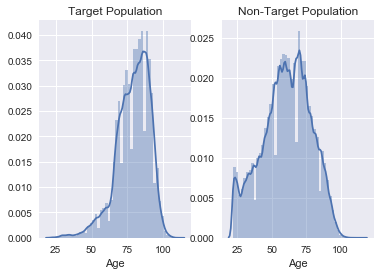

In [8]:
fig, axes = plt.subplots(1, 2)

sns.distplot(df_Target['Age'],kde = True, ax=axes[0]).set_title('Target Population')
sns.distplot(df_NonTarget['Age'],kde = True, ax=axes[1]).set_title('Non-Target Population');


C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


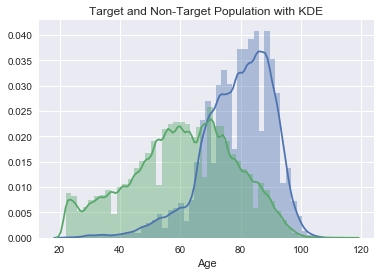

In [9]:
sns.distplot(df_Target['Age']);
sns.distplot(df_NonTarget['Age']).set_title('Target and Non-Target Population with KDE');

### MaritalStatus
* MaritalStatus: 13.7% of all Widowed patients.  None other exceeds 5.4%.

In [10]:
# Complete population likelihood of target by MAritalStatus
df_Modeling[['MaritalStatus','HasAcuteERIn6Mths']].groupby(['MaritalStatus'], as_index=False).agg(['mean', 'count']).reset_index()

MaritalStatus HasAcuteERIn6Mths         
                             mean    count
0                         0.04100      561
1             D           0.05363   110153
2             M           0.03762  1017707
3             P           0.00000        1
4             S           0.04068   305541
5             U           0.01504      266
6             W           0.13733   123604
7             X           0.04513     2969

In [11]:
# Cross-tabulated by proportion of each class in Target and NonTarget.
pd.crosstab(df_Modeling['HasAcuteERIn6Mths'],df_Modeling['MaritalStatus']).apply(lambda r: r/r.sum(), axis=1)

MaritalStatus                   D       M       P       S       U       W  \
HasAcuteERIn6Mths                                                           
0                 0.00036 0.07010 0.65863 0.00000 0.19711 0.00018 0.07171   
1                 0.00031 0.08009 0.51911 0.00000 0.16849 0.00005 0.23013   

MaritalStatus           X  
HasAcuteERIn6Mths          
0                 0.00191  
1                 0.00182

### Over21AgeBracketID
* Likelihood increases at highest age bracket from 1.3% at next lowest to over 10%.  
* 90% of all Target Patients are in the highest age bracket, which is the "65 Plus" age bracket.

In [12]:
# Complete population likelihood of target by Over21AgeBracketID
df_Modeling[['Over21AgeBracketID','HasAcuteERIn6Mths']].groupby(['Over21AgeBracketID'], as_index=False).agg(['mean', 'count']).reset_index()

Over21AgeBracketID HasAcuteERIn6Mths        
                                  mean   count
0                  1           0.00197  102785
1                  2           0.00351  143897
2                  3           0.00704  218842
3                  4           0.01318  495877
4                  5           0.10149  843483

In [13]:
# Cross-tabulated by proportion of Target vs NonTarget
pd.crosstab(df_Modeling['HasAcuteERIn6Mths'],df_Modeling['Over21AgeBracketID']).apply(lambda r: r/r.sum(), axis=1)

Over21AgeBracketID       1       2       3       4       5
HasAcuteERIn6Mths                                         
0                  0.05997 0.08383 0.12704 0.28608 0.44308
1                  0.00214 0.00535 0.01633 0.06927 0.90692

### HasMedicareIns
* Almost 63% of target patients have Medicare.
* Non-target population is less than half as likely to have Medicare at 29%.

In [14]:
# Complete population likelihood of target by HasMedicareIns
df_Modeling[['HasMedicareIns','HasAcuteERIn6Mths']].groupby(['HasMedicareIns'], as_index=False).agg(['mean', 'count']).reset_index()

HasMedicareIns HasAcuteERIn6Mths         
                              mean    count
0              0           0.02811  1250190
1              1           0.10681   554694

In [15]:
# Cross-tabulated by proportion of Target vs NonTarget
pd.crosstab(df_Modeling['HasAcuteERIn6Mths'],df_Modeling['HasMedicareIns']).apply(lambda r: r/r.sum(), axis=1)

HasMedicareIns          0       1
HasAcuteERIn6Mths                
0                 0.71035 0.28965
1                 0.37229 0.62771

### OPPLast6Mths
* Stacked at 0 in both Target and NonTarget population, but beyond that there is a clearly visible trend of higher values for the Target population.
* OPPLast6Mths removed from final model due to multicolinearity.

C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


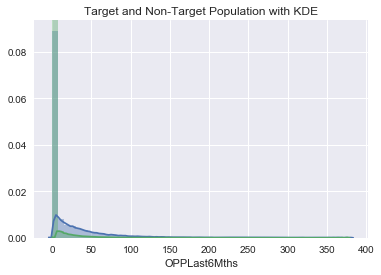

In [16]:
df_TargetOPP = df_Target[df_Target['OPPLast6Mths'] <= 379].copy(deep=True)
df_NonTargetOPP = df_NonTarget[df_NonTarget['OPPLast6Mths'] <= 379].copy(deep=True)

sns.distplot(df_TargetOPP['OPPLast6Mths']);
sns.distplot(df_NonTargetOPP['OPPLast6Mths']).set_title('Target and Non-Target Population with KDE');

# Complete population likelihood of target by UsualProviderTitle
#df_Modeling[['OPPLast6Mths','HasAcuteERIn6Mths']].groupby(['OPPLast6Mths'], as_index=False).agg(['mean', 'count']).reset_index()

### CntInpatient
* Stacked at 0 in both Target and NonTarget population, but beyond that there is a clearly visible trend of higher values for the Target population.

C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


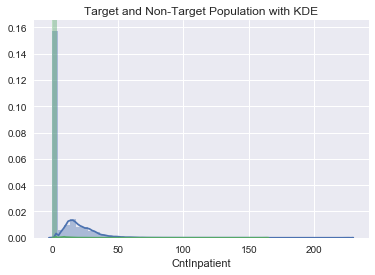

In [17]:
sns.distplot(df_Target['CntInpatient']);
sns.distplot(df_NonTarget['CntInpatient']).set_title('Target and Non-Target Population with KDE');

### CntIsERClaim
* Stacked at 0 in both Target and NonTarget population, but beyond that there is a clearly visible trend of higher values for the Target population.

C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


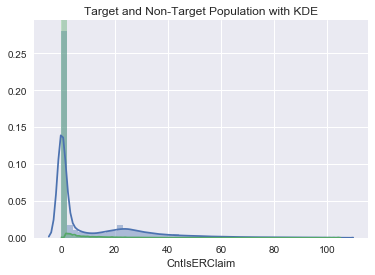

In [18]:
df_TargetER = df_Target[df_Target['CntIsERClaim'] <= 105].copy(deep=True)
df_NonTargetER = df_NonTarget[df_NonTarget['CntIsERClaim'] <= 105].copy(deep=True)

sns.distplot(df_TargetER['CntIsERClaim']);
sns.distplot(df_NonTargetER['CntIsERClaim']).set_title('Target and Non-Target Population with KDE');

# Prep Data For Model Fitting

In [19]:
df_Modeling = df_Modeling[['IsCOPD', 'IsDiabetes', 'IsHeartFailure', 'IsHypertension', 'IsChronicKidney'
                       , 'OPPLast6Mths', 'OPP3MonthAvg', 'HasPreviousAdmit', 'Has1MonthSurgery', 'Has3MonthSurgery'
                      , 'HasMedicareIns', 'Age', 'CntInpatient', 'CntIsAcuteInpatient', 'CntIsSubAcuteInpatient'
                      , 'CntIsERClaim', 'IsAcuteERPrev', 'MaritalStatus', 'Over21AgeBracketID', 'HasAcuteERIn6Mths']]

# Change Over21AgeBracketID to Categorical data type
df_Modeling['Over21AgeBracketID'] = df_Modeling['Over21AgeBracketID'].astype('category')

# Convert MaritalStatus and Over21AgeBracketID to dummy variables.
df_Modeling = pd.get_dummies(df_Modeling)

# Fill NULLS with 0 to avoid errors.
df_Modeling = df_Modeling.fillna(0)

# "Leave One Out" for each dummy category
df_Modeling = df_Modeling.drop(columns=['MaritalStatus_ ', 'Over21AgeBracketID_1']) 

# Add selected columns to a new array.
cols=['IsCOPD', 'IsDiabetes', 'IsHeartFailure', 'IsHypertension', 'IsChronicKidney'
      , 'OPPLast6Mths', 'HasPreviousAdmit' , 'Has3MonthSurgery', 'HasMedicareIns'
      , 'CntInpatient', 'CntIsERClaim'
      , 'MaritalStatus_D', 'MaritalStatus_M', 'MaritalStatus_S', 'MaritalStatus_W'
      , 'Over21AgeBracketID_2', 'Over21AgeBracketID_3', 'Over21AgeBracketID_4', 'Over21AgeBracketID_5']

# Train set
X=df_Modeling[cols]
y=df_Modeling['HasAcuteERIn6Mths']

# Add intercept
X = sm.add_constant(X)

# SKLearn Logistic Regression Model

* As is standard data science practice, the data is split into a training and test set.
* The Training set is typically 2/3 of the available data which the algorithm uses to build the model.
* The Test set is a "holdout" set which the model has not analyzed and can therefore be used to test the model's performance against new data. 

In [20]:
# Fit Logistic Regression model with SKLearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(class_weight={0:.9, 1:.1})
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.9, 1: 0.1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [21]:
# Accuracy is the proportion of true positives and true negatives vs false positives and false negatives.
# In your confusin matrix, it's top-left + bottom-right / total.
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


## Statsmodels Output

* The model is already created above using SKLearn.  However, running this StatsModels procedure gives us some output that is not readily available from SKLearn.
* While the model is not specified *exactly* the same as the SKLearn model, this output would indicate if there were certain types of issues, and also gives us a look at some additional parameters.

In [22]:
logit_model=sm.Logit(y_train,X_train,weights={0:.9, 1:.1})
result=logit_model.fit(maxiter=200)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.138735
         Iterations 10
                           Results: Logit
Model:                Logit             Pseudo R-squared: 0.323      
Dependent Variable:   HasAcuteERIn6Mths AIC:              350600.7810
Date:                 2018-08-13 10:51  BIC:              350841.7676
No. Observations:     1263418           Log-Likelihood:   -1.7528e+05
Df Model:             19                LL-Null:          -2.5874e+05
Df Residuals:         1263398           LLR p-value:      0.0000     
Converged:            1.0000            Scale:            1.0000     
No. Iterations:       10.0000                                        
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -6.3537   0.0888 -71.5523 0.0000 -6.5278 -6.1797
IsCOPD         

## Get Model Parameters
* The coefficient is the log odds of the feature.
* When exponentiated this gives us the odds ratio, which can be interpreted roughly as "The odds increase/decrease per unit with all other things being the same."

In [28]:
# Get the coefficient and log odds for each feature
# Coefficient is the log odds
# Exponentiating the coefficients gives you the odds ratios.

# Collect each feature into a list
variables=X_train.columns.values.tolist()

# Write feature name, coefficient odds ratio of all features to df
df_Params = pd.DataFrame(list(zip(variables, logreg.coef_[0], np.exp(logreg.coef_)[0])), columns=['Feature', 'Coefficient', 'OddsRatio'])

#Display
df_Params

Feature  Coefficient  OddsRatio
0                  const     -3.97103    0.01885
1                 IsCOPD      0.51006    1.66540
2             IsDiabetes      0.11708    1.12421
3         IsHeartFailure      0.58452    1.79413
4         IsHypertension     -0.07427    0.92842
5        IsChronicKidney      0.25788    1.29418
6           OPPLast6Mths      0.00380    1.00381
7       HasPreviousAdmit      1.02534    2.78803
8       Has3MonthSurgery      0.71442    2.04301
9         HasMedicareIns      0.35418    1.42502
10          CntInpatient      0.16170    1.17550
11          CntIsERClaim      0.00029    1.00029
12       MaritalStatus_D     -0.35293    0.70263
13       MaritalStatus_M     -0.60923    0.54377
14       MaritalStatus_S     -0.14944    0.86119
15       MaritalStatus_W     -0.06478    0.93727
16  Over21AgeBracketID_2      0.17164    1.18725
17  Over21AgeBracketID_3      0.86709    2.37998
18  Over21AgeBracketID_4      1.30406    3.68422
19  Over21AgeBracketID_5      2.65704   14.25397

# Goodness of Fit

How well does the model perform against real data from the holdout set?

## Cross-Validation

In [29]:
#10-Fold Cross-Validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression(class_weight={0:.9,1:.1})
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.952


## Confusion Matrices

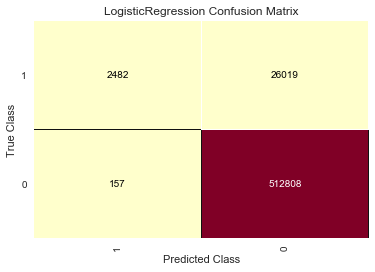

In [30]:
# Confusion Matrix Totals
cm = ConfusionMatrix(logreg, classes=[1,0], percent=False)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

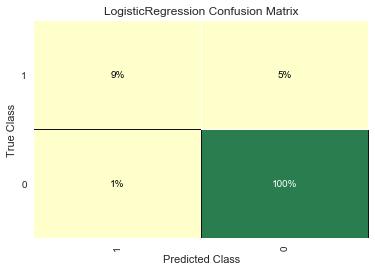

In [31]:
cm = ConfusionMatrix(logreg, classes=[1,0], percent=True)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

In [32]:
# Calculate Precision, Recall, F-Measure and Support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.98    512965
          1       0.94      0.09      0.16     28501

avg / total       0.95      0.95      0.93    541466



**Precision** = TP / (TP+FP)
    Precision is sort of like accuracy but it looks only at the data you predicted positive.
    
**Recall** = TP / (TP+FN)
    Recall is also sort of like accuracy but it looks only at how you did on the data that actually is positive.

**f1-score** = 2 * (precision * recall) / (precision + recall)
    The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

## Gains/Lift Chart

C:\Users\bburns.PROHEALTH.000\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


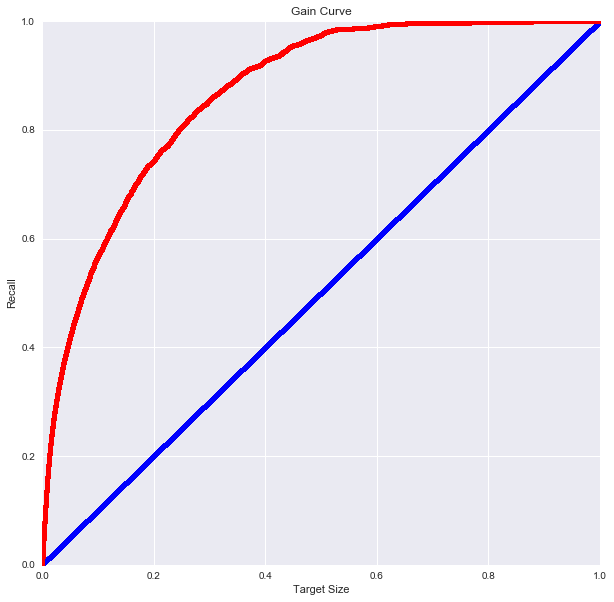

In [33]:
#calculate the posterior probabilities for the test sample
probas = logreg.predict_proba(X_test)

#score for 'presence‘ (positive class value)
score = probas[:,1] 

#transforming in 0/1 (dummy variables) the Y_test vector
pos = pd.get_dummies(y_test).as_matrix()

#get the second column (index = 1)
pos = pos[:,1] 

#number of “positive” instances
npos = np.sum(pos) 

#indices that would sort according to the score
index = np.argsort(score) 

#invert the indices, first the instances with the highest score
index = index[::-1] 

#sort the class membership according to the indices
sort_pos = pos[index] 

#cumulated sum
cpos = np.cumsum(sort_pos) 

#recall column
recall = cpos/npos 

#nb. of instances into the test set
n = y_test.shape[0] 

#target size
target = np.arange(start=1,stop=(n + 1),step=1)

#target size in percentage
target = target / n 

# Set size of plot
plt.figure(figsize=(10,10))

#title and axis labels
plt.title('Gain Curve')
plt.xlabel('Target Size')
plt.ylabel('Recall')

#limits in horizontal and vertical axes
plt.xlim(0,1)
plt.ylim(0,1)

#tricks to represent the diagonal
plt.scatter(target,target,marker='.',color='blue')

#gains curve
plt.scatter(target,recall,marker='.',color='red')

#show the chart
plt.show()

# Conclusions

**Model Performance in Test and Cross-Validation**
* Cross-Validated model performance is 95.2% accuracy, with a false positive rate around 1%.
* Over the two years from 2016-2017 we predicted 2,482 true positives with only 152 false positives.
* Using ProHealth's own estimate of cost incurred for these events, these identified targets represent \$37,651,940 in cost/risk in the Test data, which can be extrapolated to \$124,251,402 over the two years 2016 and 2017 if the model had been running during that time. 
* Assuming a stable enviroment and data provenance, these results should also remain attainable going forward.

**Next Steps**
* We've included a list of potential model improvements in an appendix below.  Any or all of these improvements may be considered as next steps; the model may also be further implemented as is.
* A list of 280 at-risk Patients has been generated for 2018 data.  These are patients that may be considered at-risk now.
* Once the model is considered complete or acceptable, business and clinical leaders should begin discussing interventions and treatments for the identified at-risk patients.


 **Note:** *Current model is specifically weighted with a priority on avoiding false positives.  Other iterations of our modeling identified many more at-risk patients, and also had many more false positives.*

# Get 2018 Predictions

Make new predictions for 2018.  Get list of current at-risk patients.

## Prep New 2018 Data For Prediction

In [34]:
df_GetPredict = df_Predict2018[['PatientID', 'DateMonthlyID','IsCOPD', 'IsDiabetes', 'IsHeartFailure', 'IsHypertension', 'IsChronicKidney'
                       , 'OPPLast6Mths', 'OPP3MonthAvg', 'HasPreviousAdmit', 'Has1MonthSurgery', 'Has3MonthSurgery'
                      , 'HasMedicareIns', 'Age', 'CntInpatient', 'CntIsAcuteInpatient', 'CntIsSubAcuteInpatient'
                      , 'CntIsERClaim', 'IsAcuteERPrev', 'MaritalStatus', 'Over21AgeBracketID', 'HasAcuteERIn6Mths']].copy(deep=True)

# Change Over21AgeBracketID to Categorical data type
df_GetPredict['Over21AgeBracketID'] = df_GetPredict['Over21AgeBracketID'].astype('category')

# Convert MaritalStatus and Over21AgeBracketID to dummy variables.
df_GetPredict = pd.get_dummies(df_GetPredict)

# Fill NULLS with 0 to avoid errors.
df_GetPredict = df_GetPredict.fillna(0)

# "Leave One Out" for each dummy category
df_GetPredict = df_GetPredict.drop(columns=['MaritalStatus_ ', 'Over21AgeBracketID_1']) 

df_GetPredict = df_GetPredict[['IsCOPD', 'IsDiabetes', 'IsHeartFailure', 'IsHypertension', 'IsChronicKidney'
                           , 'OPPLast6Mths', 'HasPreviousAdmit' , 'Has3MonthSurgery', 'HasMedicareIns'
                           , 'CntInpatient', 'CntIsERClaim'
                           , 'MaritalStatus_D', 'MaritalStatus_M', 'MaritalStatus_S', 'MaritalStatus_W'
                           , 'Over21AgeBracketID_2', 'Over21AgeBracketID_3', 'Over21AgeBracketID_4', 'Over21AgeBracketID_5'
                           ]]

# Add intercept
df_GetPredict = sm.add_constant(df_GetPredict)

## Run 2018 Predictions

In [35]:
# Get predictions for 2018 data
y_pred2018 = logreg.predict(df_GetPredict)

# Get probabilities for predictions (comes as list of arrays)
y_prob = logreg.predict_proba(df_GetPredict)

# Bring list of arrays into columns in a df
df_prob = pd.DataFrame(y_prob)

# Combine lists into single df (df_prob has two columns)
df_LabeledPredictions2018 =  pd.DataFrame(np.column_stack([df_Predict2018['PatientID'], df_Predict2018['DateMonthlyID'], y_pred2018, df_prob]), 
                                columns=['PatientID', 'DateMonthlyID', 'Prediction', 'Prob0', 'Prob1'])

# Save to excel to examine
# df_LabeledPredictions2018.to_excel('C:/Users/bburns.PROHEALTH.000/Desktop/Ben Burns/NewPredictions_08122018.xlsx')

In [36]:
# Count of total 2018 records prediction was run against.
df_LabeledPredictions2018.shape

(173300, 5)

In [37]:
# Total number of positive predicitons in the 2018 records.
df_LabeledPredictions2018['Prediction'].sum()

280.0

# Appendix1: Potential for Further Improvement

Given that this is largely a proof of concept project and one of two main sponsors is leaving the organization soon, there are improvements that can be made to the model just by further analysis of the current effects we've been reviewing.

However, below is a list of more substantive improvements (aside from Inspecting Outliers, which falls more under refining the current analysis) that could be undertaken to enhance ProHealth's ability to identify at-risk Patients.  These are loosely presented in order of smallest to greatest expected effort.

## Inspecting Outliers

* OPPLast6Mths, CntInpatient, CntIsAcuteInpatient, CntIsSubAcuteInpatient, CntIsERClaim all have potential outlier values at the far end of their ranges.  Inspecting these and possibly transforming or otherwise "dealing with" them could potentially yield better results.

## Breakout Target Over/Under 65

The  major areas of difference that stand out are the Under 65 group is:
    * More likely to have IsDeppressionOrBH (43.6% vs 27.4%)
    * 13% more likely to be Obese
    * MUCH more likely to have Medicaid (76.4% vs 28%)
    * More likely to have Collection (37.6% vs 15%)
    * More frequent ER claims (15.76 vs 10.93) and Previous ER claims (17.55 vs 11.01)

## Claim Lifecycle
* Due to time constraints there are still gaps in our knowledge of the specifics around the claim lifecycle.  For example, looking at the predictions, we have only positive predictions for Patients in the early part of the year.  The hypothesis for this effect is that it is likely due to incomplete claim information for very recent claims.

* While this does not mean these Patients are no longer at risk because their 6 month prediction window is almost up, it possibly means some lost time or missed opportunities for treatment.  Recommendation would be to work more closely with the business leaders and data owners to either rely less on incomplete claims data, or to better tune the model for more recent claims.

## Fit a companion-model for Attributed Patients
* Attributed members who are not also ProHealth Patients (do not have a ProhHealth ID) are not included in this model.
* It is possible that a model could be adapted for these non-Patient Attributed Members, as well.
    * Many fields in the model are drawn from claims only: OPPLast6Mths, HasPreviousAdmit, CntInpatient, CntIsERClaim
    * Other fields could be adapted from claims data: Age, MaritalStatus (kind of).
    * Additional Payor fields may be included.

## Social Determinant Analysis
* While demographic features such as Race, Ethnicity, Gender, etc did not prove particularly predictive, there were strikingly few available features that might be considered social determinants.
* Factors such as income, employment status, occupation, housing status, education lever, etc can often be predictive.
* Given more time, some of these factors may be derived.
* Partnership with social service and nonprofit organizations could also be considered -SMC may be able to help coordinate.
* Pop Health and Census data can sometimes be useful in this arena, but is often aggregated by zip code or other geography rather than specific to individual patients.

## Refinement of Target
* Because it is very difficult to label claims according to which are unplanned, specifically, we had to count the acute inpatient claim coinciding with an ER visit to determine if it met our criteria.  
* There may be opportunities to further refine this target, or perhaps devise a more sophisticated maner of labeling claims.
* Given that this project is technically a "proof of concept" there may also be opportunities to refine the target for higher impact and ROI through a rigorous cost-benefit analysis with business and clinical leaders.